# Genetic Programming Algorithm Prototype
## 22900426

Image name (shape) (intensity max, min, mean, std)

original_ga (240, 720) (210, 0, 49.3, 34.8)


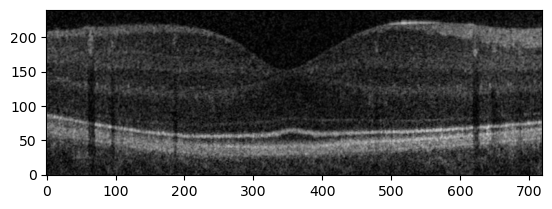

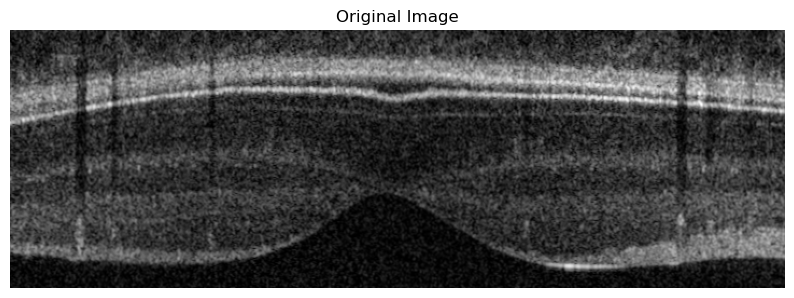

In [1]:
# Initial File IO Initialization
# Use functions specified in worm.py
from worm import Camo_Worm, Drawing, initialise_clew, prep_image
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import sobel
import cv2

IMAGE_DIR = 'ga_temp/'
IMAGE_NAME = 'original_ga'
MASK = [320, 560, 160, 880]  # Example: ymin, ymax, xmin, xmax
rng = np.random.default_rng()

# Genetic algorithm parameters
NUM_GENERATIONS = 50
POPULATION_SIZE = 20
INIT_PARAMS = (40, 30, 1)  # Example parameters for worm initialization

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

<Figure size 640x480 with 0 Axes>

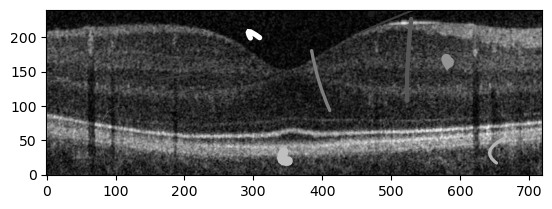

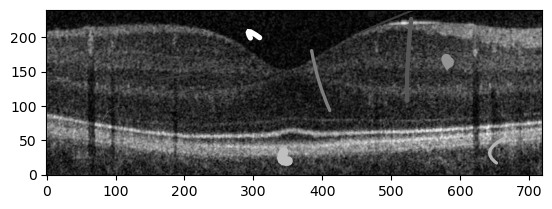

In [2]:
def calculate_fitness(image, clew, drawing):

    # Render the image with worms applied
    drawing.add_worms(clew)
    drawing.fig.canvas.draw()
    modified_image = np.array(drawing.fig.canvas.renderer.buffer_rgba())
    modified_image = cv2.resize(modified_image, (image.shape[1], image.shape[0]))
    modified_image = modified_image[:image.shape[0], :image.shape[1], :]

    # Convert RGBA to grayscale for analysis
    modified_image_gray = np.dot(modified_image[..., :3], [0.2989, 0.5870, 0.1140])

    # Use Sobel filter
    edges_original = sobel(image)
    edges_modified = sobel(modified_image_gray)

    # Calculate the MSE
    edge_clarity = np.mean((edges_modified - edges_original) ** 2)
    noise_reduction = -np.var(modified_image_gray - image)
    fitness_score = -edge_clarity + noise_reduction

    return fitness_score

    
def select_parents(population, fitnesses, k=3):
    """Tournament selection."""
    tournament = rng.choice(len(population), size=k, replace=False)
    best = np.argmax(fitnesses[tournament])
    return population[tournament[best]]
    
def crossover(parent1, parent2):
    """Single-point crossover."""
    point = rng.integers(1, len(parent1))
    return parent1[:point] + parent2[point:]
    
def mutate(clew, mutation_rate=0.1):
    """Randomly alter worm parameters with a given mutation rate."""
    for worm in clew:
        if rng.random() < mutation_rate:
            # Randomly mutate properties of the worm
            worm.r += rng.normal(0, 5)  # Adjust radius slightly
    return clew

def tournament_selection(population, fitnesses, tournament_size=3):
    indices = rng.choice(len(population), size=tournament_size, replace=False)
    tournament_population = [population[i] for i in indices]
    tournament_fitnesses = [fitnesses[i] for i in indices]
    best_index = np.argmax(tournament_fitnesses)
    return tournament_population[best_index]

    
def genetic_algorithm(image, num_generations=50, population_size=20, init_params=(40, 30, 1)):
    # Initialize population
    population = [initialise_clew(10, image.shape, init_params) for _ in range(population_size)]
    
    # Create a Drawing object (only for fitness calculation, not for display)
    drawing = Drawing(np.copy(image))  

    # Calculate initial fitness for the entire population
    fitnesses = [calculate_fitness(image, clew, drawing) for clew in population]

    # Evolution process
    for generation in range(num_generations):
        new_population = []
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate=0.1)
            new_population.append(child)

        population = new_population
        fitnesses = [calculate_fitness(image, clew, drawing) for clew in population]

    best_index = np.argmax(fitnesses)
    best_clew = population[best_index]

    plt.clf()   
    final_drawing = Drawing(np.copy(image))
    final_drawing.add_worms(best_clew)
    final_drawing.show(save='ga_temp/final_best_result.png')  # Optionally save the final result
    
    # Display the final best result
    plt.show()
    
    return best_clew

# Run GP Algorithm
best_clew = genetic_algorithm(image, NUM_GENERATIONS, POPULATION_SIZE, INIT_PARAMS)

# Show the enhanced image with worms
drawing = Drawing(image)
drawing.add_worms(best_clew)
drawing.show(save='ga_temp/ga_result.png')
